In [1]:
# Data Source: https://www.alphavantage.co
# API Key: EVMRD162IRCITXSI

In [2]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Download stock historical data and visualize it
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.techindicators import TechIndicators
ts = TimeSeries(key='EVMRD162IRCITXSI',output_format='pandas')
fd=FundamentalData(key='EVMRD162IRCITXSI',output_format='pandas')
TI=TechIndicators(key='EVMRD162IRCITXSI',output_format='pandas')
# Get json object with the intraday data and another with  the call's metadata

In [5]:
# Download stock historical data
stock_data,stock_meta_data=ts.get_daily_adjusted('AAPL',outputsize='full')

In [11]:
# Download stock technical indicators
ema_data,ema_matadata=TI.get_ema('AAPL', interval='daily', time_period=100, series_type='close')
macd_data,macd_matadata=TI.get_macd('AAPL', interval='daily', series_type='close')
stoch_data,stock_matadata=TI.get_stoch('AAPL', interval='daily')
rsi_data,rsi_matadata=TI.get_rsi('AAPL', interval='daily', time_period=100)

In [10]:
obv_data,obv_matadata=TI.get_obv('AAPL', interval='daily')

In [12]:
# Using the most recent five year historical stock price data for analysis
stock_price = stock_data[stock_data.index > '2000-03-24']['5. adjusted close']
ema_recent = ema_data[ema_data.index > '2000-03-24']['EMA']
macd_recent = macd_data[macd_data.index > '2000-03-24']['MACD_Signal']
obv_recent = obv_data[obv_data.index > '2000-03-24']['OBV']
rsi_recent = rsi_data[rsi_data.index > '2000-03-24']['RSI']

In [14]:
stock_price.to_frame().join(ema_recent).join(macd_recent).join(rsi_recent).join(obv_recent)

,5. adjusted close,EMA,MACD_Signal,RSI,OBV
date,,,,,
2021-03-03,122.060000,124.6167,-1.6684,52.2472,9.450345e+10
2021-03-02,125.120000,124.6684,-1.4272,53.0887,9.461641e+10
2021-03-01,127.790000,124.6592,-1.1855,53.8376,9.471867e+10
2021-02-26,121.260000,124.5960,-0.8905,52.2050,9.460237e+10
2021-02-25,120.990000,124.6634,-0.4717,52.1357,9.443894e+10
...,...,...,...,...,...
2000-03-31,1.044346,0.8413,0.0412,57.3353,9.575069e+09
2000-03-30,0.966987,0.8372,0.0416,56.1663,9.170435e+09
2000-03-29,1.045345,0.8346,0.0418,57.7532,9.584835e+09


In [21]:
#组合为矩阵，与数据归一化
from sklearn.preprocessing import MinMaxScaler
ema=np.array(ema_recent).reshape(len(ema_recent),1)
macd=np.array(macd_recent).reshape(len(ema_recent),1)
obv=np.array(obv_recent).reshape(len(ema_recent),1)
rsi=np.array(rsi_recent).reshape(len(ema_recent),1)
sp=np.array(stock_price).reshape(len(ema_recent),1)
scaler=MinMaxScaler()
ema=scaler.fit_transform(ema)
macd=scaler.fit_transform(macd)
obv=scaler.fit_transform(obv)
rsi=scaler.fit_transform(rsi)
sp=scaler.fit_transform(sp)
data_jihe=np.hstack([ema,macd,obv,rsi,sp])

In [22]:
data_jihe

array([[0.00483639, 0.1958447 , 0.22623543, 0.52953888, 0.85368397],
       [0.00487575, 0.21844865, 0.22454338, 0.52742094, 0.87512096],
       [0.00490948, 0.24109946, 0.22254394, 0.51171797, 0.89382578],
       ...,
       [0.99937035, 0.35611534, 0.93227241, 0.39117974, 0.00590965],
       [0.99944424, 0.35595603, 0.9314199 , 0.36812553, 0.00608149],
       [0.99902903, 0.35571237, 0.93047814, 0.3422207 , 0.00610466]])

In [182]:
dataset=data_jihe.reshape(-1,5)
# 调整数据集顺序，使train集是历史数据
dataset = dataset[::-1]

# 准备训练数据
train_size=int(len(dataset)*0.65)
train_list=dataset[:train_size]
test_list=dataset[train_size-1:]

y_train = train_list[:, -1]
train_list = np.delete(train_list, -1, axis=1)
X_train = train_list[:, :]

y_test = test_list[:, -1]
test_list = np.delete(test_list, -1, axis=1)
X_test = test_list[:, :]

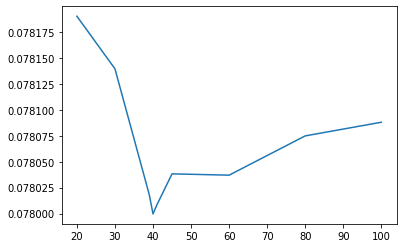

In [203]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# 找 mse 小的 n_estimators 参数
mse=[]
estimators_number = [20,30,39,40,41,45,60,80,100]
for i in estimators_number:
    regressor = RandomForestRegressor(n_estimators=i, oob_score=True, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse.append(metrics.mean_squared_error(y_test, y_pred))
    
plt.plot(estimators_number,mse)

In [204]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 训练随机森林解决回归问题

regressor = RandomForestRegressor(n_estimators=40, oob_score=True, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.20180660243390794
Mean Squared Error: 0.07799964335943714


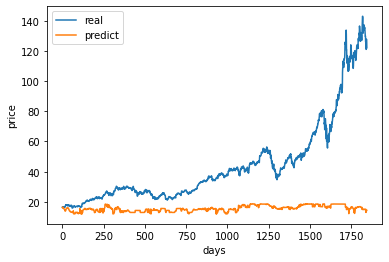

In [211]:
#画图
y_test = y_test.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)
y=scaler.inverse_transform(y_test)
y1=scaler.inverse_transform(y_pred)

plt.plot(y,label='real')
plt.plot(y1,label='predict')
plt.ylabel('price')
plt.xlabel('days')
plt.legend()
plt.show()

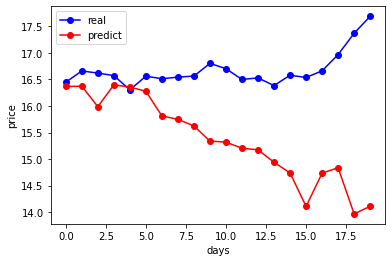

In [212]:
plt.plot(y[:20,-1],'bo-',label='real')
plt.plot(y1[:20,-1],'ro-',label='predict')
plt.ylabel('price')
plt.xlabel('days')
plt.legend()
plt.show()